## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split

In [9]:
if torch.cuda.is_available():
    torch_device = torch.cuda.current_device()
    print("PyTorch detected GPU:", torch.cuda.get_device_name(torch_device))
else:
    print("PyTorch did not detect GPU")

PyTorch detected GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [10]:
print("CUDA version PyTorch is using:", torch.version.cuda)

CUDA version PyTorch is using: 12.1


In [11]:
torch.__version__

'2.1.2+cu121'

In [12]:
import torchtext
torchtext.__version__ 

'0.16.2+cpu'

### Wczytanie i analiza danych

In [2]:
# !kaggle datasets download -d andrewmvd/steam-reviews

In [3]:
# import zipfile
# with zipfile.ZipFile('steam-reviews.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [14]:
def plot_classes_balance(data: pd.DataFrame):
    color_dict = {0: "red", 1: "green"}

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    sns.countplot(x='review_score', data=data, hue='review_score', palette=[color_dict[0], color_dict[1]], ax=axs[0])
    data['review_score'].value_counts().plot.pie(autopct='%1.1f%%', colors=[color_dict[1], color_dict[0]], ax=axs[1])
    fig.suptitle('Users Recommendations')
    plt.tight_layout()

In [15]:
# Wyświetlenie całej zawartości kolumny
pd.set_option('display.max_colwidth', None)

# Wczytanie danych
reviews_df = pd.read_csv('data/dataset.csv')
reviews_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like games that don't lag? • Do you like games you can run on low end PC's? • Do you like games where you don't meet children who have slept with your mother? Then this is for you!,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [16]:
reviews_df['review_score'].value_counts()

review_score
 1    5260420
-1    1156686
Name: count, dtype: int64

Zmiana wartości klasy z *-1* na *0*

In [17]:
reviews_df['review_score'].replace(-1, 0, inplace=True)
reviews_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like games that don't lag? • Do you like games you can run on low end PC's? • Do you like games where you don't meet children who have slept with your mother? Then this is for you!,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [18]:
reviews_df[['app_name', 'review_text', 'review_score']].sample(20)

,app_name,review_text,review_score
3658635,The Witcher 3: Wild Hunt,"fantastig RPG game. While frustrating at times and some controls are consolish, the world is believable and you care about the protagonists.",1
2899034,Ikaruga,"Ever since hearing about this bullet hell a while after it had come out for the GameCube, I had been itching to give it a try, but finding a copy of it proved to be out of my range, so you can imagine my surprise and delight when I noticed it had been released on Steam. For the most part, it follows the tried and true standards of the upwards scrolling arcade bulletspam shooter. Maneuver your ship to avoid bullet spreads, while cutting through wave after wave of grunts, to eventually make your way to the boss. Pretty cut and dry, as far as concept goes, right? Wrong. Although it definitely sticks to the mechanics laid down by its predecessors, Ikaruga lays down its own twist, through the bullets themselves. There are two differently colored ships shooting correspondingly colored bullets at you in the game, black and white, and this is where it gets interesting. The color of your ship can be changed from black to white on the fly with the press of a button, to match either of the incoming bullets, and as long as your ship matches the color of the bullet hitting you, you will absorb it into an energy meter to release later as an energy blast upon your unsuspecting enemies. Touch the opposite color bullet of yourself, and you die. Shooting chains of the same colored enemy helps build up your score faster. On top of this, shooting an enemy with a bullet that is the opposite color of them, does more damage, and thereby allows you to plow through them faster. Easy enough, right? Well it would be if this wasn't a bullet hell. Even on the easiest setting, this game provides a challenge, having you dodge varying patterns of enemy waves, the occasional obstacle thrown in your path, and of course the ever present swarms of multicolored bullets being peppered at you from all over. The game includes a replay system, and leaderboards (I'm not sure if they're only local or across the internet, haven't checked it yet), and is currently here on steam for $9.99. Expectations aside, I would give this game an 8/10",1
5005915,Fallout,"I love it. Runs amazing on modern systems, although on 1920x1080 the text is quite small.",1
1425030,DayZ,Early Access Review,1
4207687,The Secret of Monkey Island: Special Edition,A very good point and click adventure game!,1
112247,Terraria,Absurdly fun. Dangerously addictive.,1
3710991,Mount Your Friends,I've played just over 16 hours and I've got to say they were and are some of the funnest bit of time I've had playing this game. The only thing that sucks is that using a controller is the easier (in my opinion) way to play this game.,1
2550535,NaN,"if you have ANY streaming softwere that is picked up as a camra this game will refuse to work, not worth buying or playing in that case since I'm not removing streaming softwear for it.",0
2453198,Space Engineers,Early Access Review,1
1045906,Rocketbirds: Hardboiled Chicken,This game sucks. But has a great theme song,1


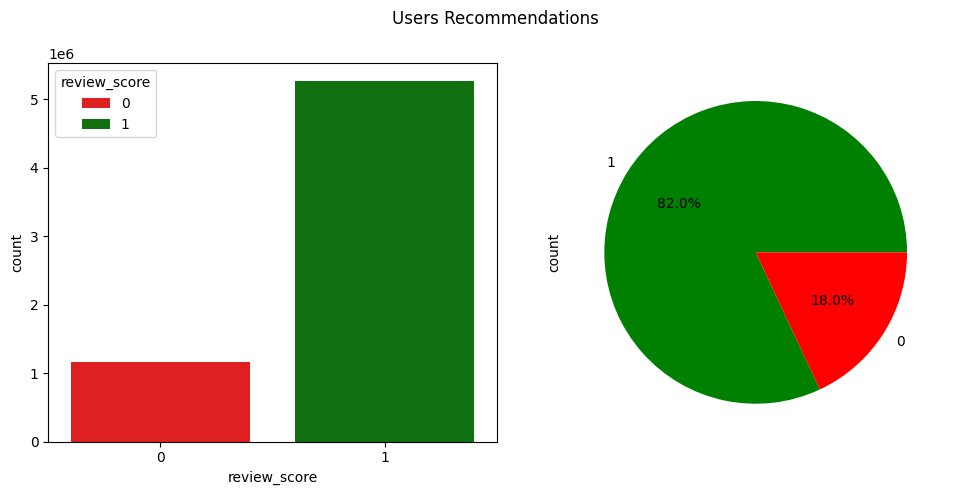

In [19]:
plot_classes_balance(reviews_df)

In [20]:
reviews_df['review_text'] = reviews_df['review_text'].str.strip()
reviews_df = reviews_df[(reviews_df['review_text'] != 'Early Access Review') & (reviews_df['review_votes'] != 0)]
reviews_df.reset_index(drop=True, inplace=True)
reviews_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",1,1
1,10,Counter-Strike,"Easy to learn, hard to master.",1,1
2,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1
3,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,1
4,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben cant steal our money 10/10 would play again",1,1


In [21]:
reviews_df['review_score'].value_counts()

review_score
1    545897
0    222160
Name: count, dtype: int64

In [22]:
reviews_df[reviews_df['review_text'].str.len() <= 0]

,app_id,app_name,review_text,review_score,review_votes
10050,105600,Terraria,,1,1
54627,203770,Crusader Kings II,,1,1
112457,218620,PAYDAY 2,,1,1
134683,22300,Fallout 3,,0,1
157583,227580,"10,000,000",,1,1
172362,233130,Shadow Warrior,,0,1
207009,2400,The Ship,,1,1
234703,249050,Dungeon of the ENDLESS™,,1,1
251461,252950,Rocket League,,1,1
251480,252950,Rocket League,,1,1


In [23]:
reviews_df['review_score'].value_counts()

review_score
1    545897
0    222160
Name: count, dtype: int64

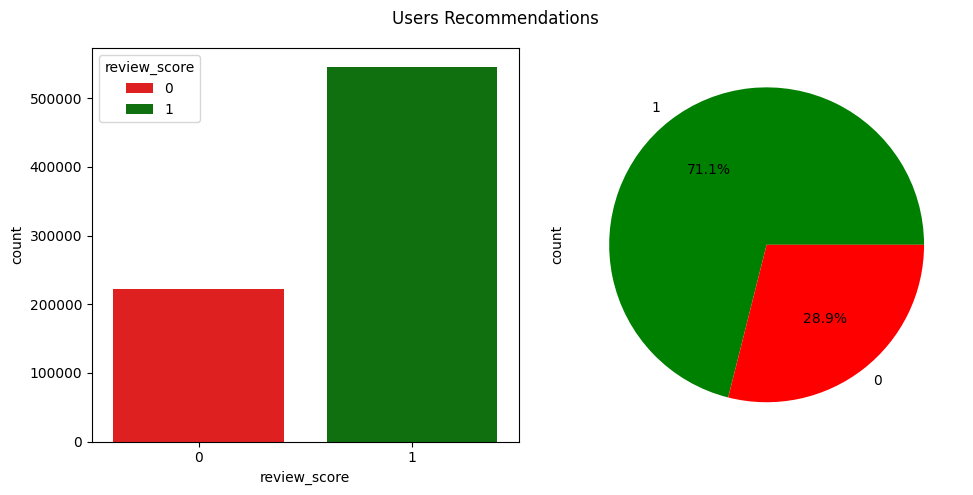

In [24]:
plot_classes_balance(reviews_df)

Po usunięciu tekstów z samym 'Early Access Review' oraz recenzji źle ocenionych przez pozostałych użytkowników (review_votes = 0) klasy dla wystawionych ocen wciąż są mocno niezbalansowane.

W związku z tym, że po wstępnej filtracji wciąż mamy bardzo dużo danych (ponad 750 000 rekordów), klasy zbalansujemy poprzez usunięcie losowych przykładów pozytywnych ocen tak, aby było ich tyle samo,
co recenzji negatywnych.

In [25]:
from sklearn.utils import resample

reviews_1 = reviews_df[reviews_df.review_score == 1]
reviews_0 = reviews_df[reviews_df.review_score == 0]

reviews_1_us = resample(reviews_1, 
                        replace=False, 
                        n_samples=len(reviews_0),
                        random_state=42)
 

reviews_df_balanced = pd.concat([reviews_1_us, reviews_0])

reviews_df_balanced['review_score'].value_counts()


review_score
1    222160
0    222160
Name: count, dtype: int64

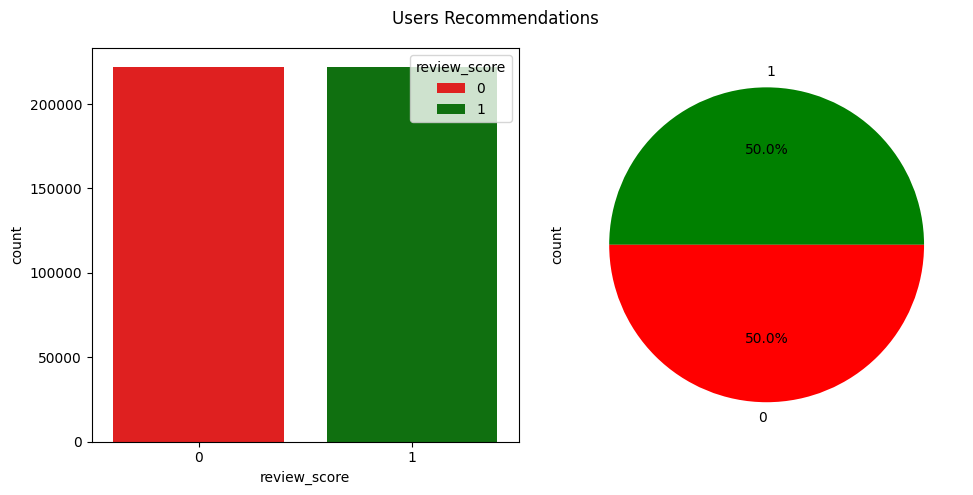

In [26]:
plot_classes_balance(reviews_df_balanced)

In [27]:
reviews_df_balanced.reset_index(drop=True, inplace=True)
reviews_df_balanced.head()

app_id             app_name  \
0  218620             PAYDAY 2   
1  248570             Toribash   
2  426790              Grow Up   
3  238460  BattleBlock Theater   
4  248820         Risk of Rain   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [28]:
df = reviews_df_balanced[['review_text', 'review_score']].reset_index(drop=True)
df.head()

review_text  \
0  This game is very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very

### Preprocessing

Usunięcie stopwords

In [13]:
# Downloading the english model
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 991.0 kB/s eta 0:00:44
     ---------------------------------------- 0.2/42.8 MB 2.0 MB/s eta 0:00:22
     ---------------------------------------- 0.4/42.8 MB 3.2 MB/s eta 0:00:14
      --------------------------------------- 0.7/42.8 MB 3.5 MB/s eta 0:00:13
      --------------------------------------- 0.9/42.8 MB 3.6 MB/s eta 0:00:12
     - -------------------------------------- 1.2/42.8 MB 3.9 MB/s eta 0:00:11
     - -------------------------------------- 1.4/42.8 MB 4.1 MB/s eta 0:00:11
     - -------------------------------------- 1.7/42.8 MB 4.3 MB/s eta 0:00:10
     - -------------------------------------- 1.9/42.8 MB 4.4 MB/s eta 0:00:10
     -- ------------------------------------- 2.2/42.8 MB 4.5 MB/s eta 0:00:10
     -- ------------------------------------- 2.4/42.8 MB 4.6 MB/s eta 0:00:09
     -- ------------------------------------- 2.7/42.8 MB 

In [29]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [30]:
def remove_stop_words(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['review_text'] = df['review_text'].astype(str).apply(remove_stop_words)
df.head()

,review_text,review_score
0,This game good,1
1,fight pro generic noob lunge thing shredded bits won~!,1
2,"Grow Up I wanted sequel Grow Home. The positives: + More collectibles + Challenges + More costumes + Huge world explore multiple biomes, new plants, animals + Mobility options built BUD instead plant based (i.e. Glider Air Break instead Flower Leaf) + Additional character POD, help find things map The negative: - BUD difficult handle challenges precise movements limited time Other negative, Ubisoft Reflections perfect sequel game proud work!",1
3,Hmmm... How this... A stupid game funny man making jokes telling story &amp; surprisingly addictive fun matter play co-op friends. 9/10,1
4,hard good (i like like that). #betterthannuclearthronexddd,1


Lowercase

In [31]:
df['review_text'] = df['review_text'].apply(lambda x: x.lower())
df.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shredded bits won~!,1
2,"grow up i wanted sequel grow home. the positives: + more collectibles + challenges + more costumes + huge world explore multiple biomes, new plants, animals + mobility options built bud instead plant based (i.e. glider air break instead flower leaf) + additional character pod, help find things map the negative: - bud difficult handle challenges precise movements limited time other negative, ubisoft reflections perfect sequel game proud work!",1
3,hmmm... how this... a stupid game funny man making jokes telling story &amp; surprisingly addictive fun matter play co-op friends. 9/10,1
4,hard good (i like like that). #betterthannuclearthronexddd,1


Usunięcie znaków specjalnych

In [32]:
df.loc[:, 'review_text'] = df['review_text'].str.replace(r"[^a-z\s']", '', regex=True)

df.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shredded bits won,1
2,grow up i wanted sequel grow home the positives more collectibles challenges more costumes huge world explore multiple biomes new plants animals mobility options built bud instead plant based ie glider air break instead flower leaf additional character pod help find things map the negative bud difficult handle challenges precise movements limited time other negative ubisoft reflections perfect sequel game proud work,1
3,hmmm how this a stupid game funny man making jokes telling story amp surprisingly addictive fun matter play coop friends,1
4,hard good i like like that betterthannuclearthronexddd,1


Lemmatyzacja

In [33]:
def lemmatize(text):
  return ' '.join(x.lemma_ for x in nlp(text))


df_lemmatized = df.copy()
df_lemmatized['review_text'] = df_lemmatized['review_text'].apply(lemmatize)

df_lemmatized.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shred bit win,1
2,grow up I want sequel grow home the positive more collectible challenge more costume huge world explore multiple biome new plant animal mobility option build bud instead plant base ie glider air break instead flower leaf additional character pod help find thing map the negative bud difficult handle challenge precise movement limited time other negative ubisoft reflection perfect sequel game proud work,1
3,hmmm how this a stupid game funny man make joke tell story amp surprisingly addictive fun matter play coop friend,1
4,hard good I like like that betterthannuclearthronexddd,1


W wyniku preprocessingu powstały puste komórki w kolumnie **review_text**. Musimy usunąć te kolumny, inaczej przy trenowaniu modelu pojawi się błąd.

In [34]:
df_lemmatized[df_lemmatized['review_text'].str.len() <= 0]

,review_text,review_score
48,,1
183,,1
291,,1
357,,1
1000,,1
...,...,...
442874,,0
442901,,0
443225,,0
443553,,0


In [35]:
df_lemmatized = df_lemmatized[df_lemmatized['review_text'].str.len() > 0].reset_index(drop=True)
df_lemmatized.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shred bit win,1
2,grow up I want sequel grow home the positive more collectible challenge more costume huge world explore multiple biome new plant animal mobility option build bud instead plant base ie glider air break instead flower leaf additional character pod help find thing map the negative bud difficult handle challenge precise movement limited time other negative ubisoft reflection perfect sequel game proud work,1
3,hmmm how this a stupid game funny man make joke tell story amp surprisingly addictive fun matter play coop friend,1
4,hard good I like like that betterthannuclearthronexddd,1


In [36]:
df_lemmatized['review_score'].value_counts()

review_score
0    221070
1    220873
Name: count, dtype: int64

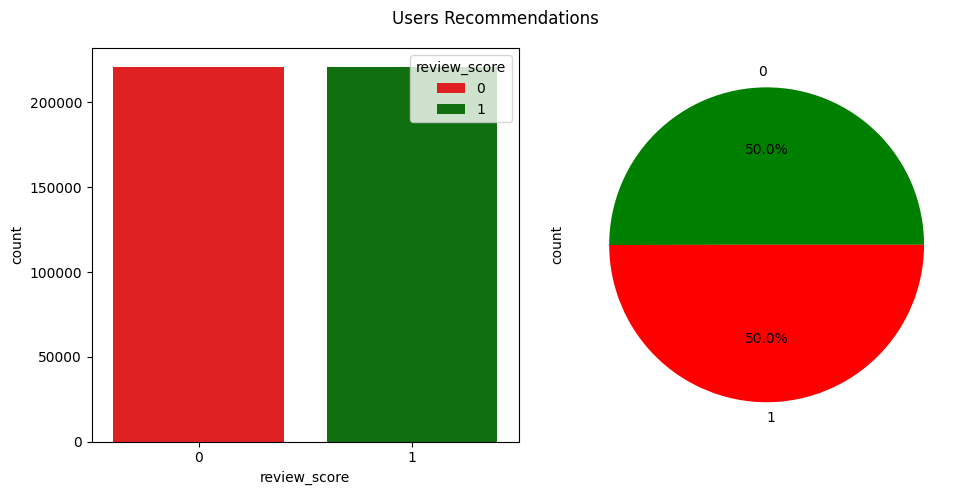

In [37]:
plot_classes_balance(df_lemmatized)

### Przygotowanie danych do modeli

Train/val/test split

In [38]:
RANDOM_SEED = 42

X = df_lemmatized[['review_text']]
y = df_lemmatized['review_score'].astype(str)

# Pierwszy podział - wyodrębnienie zbioru trenigowego, pozostałe 30% danych będzie rozdzielone na zbiór walidacyjny i testowy
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

# Drugi podział - wyodrębnienie zbioru walidacyjnego (20%) i testowego (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=RANDOM_SEED, stratify=y_temp)


In [39]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (309360, 1), y_train shape: (309360,)
X_val shape: (88388, 1), y_val shape: (88388,)
X_test shape: (44195, 1), y_test shape: (44195,)


In [40]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_data.head()

,review_text,review_score
0,you able appreciate level polish go game like leave dead killing floor play game like this I do not recommend anyone especially high price point friend play with save money else if you be look good survival horror be not it it be scary it be cryptic go depend mission be honest yourself game beta start poor actually good,0
1,overall game look nice use economic supply demand similar orginal game unfortuntely track lay ui horribly clunky I try ' double track ' section rail avail manually connect double track line matter I do not work additionally zoom limit impossible small area to add insult injury I run window os game crash twice hour play I game pass bring railroad tycoon,0
2,this game suck crash time,0
3,intuitive amp wellpresente recommend like explore nuance narrative,1
4,that art style cute love design game way short like everye bit rush throw face you hardly decision ending I guess game alright you be look pass time personally like customize character possible I think that overall rush ending worth time they,0


In [41]:
train_list = list(train_data.itertuples(index=False, name=None))
train_list[:5]

[('you able appreciate level polish go game like leave   dead killing floor play game like this I do not recommend anyone especially high   price point friend play with save money else if you be look good survival horror be not it it be scary it be cryptic go depend mission be honest yourself game beta start poor actually good',
  '0'),
 ("overall game look nice use economic supply demand similar orginal game unfortuntely track lay ui horribly clunky I try ' double track ' section rail avail manually connect double track line matter I do not work additionally zoom limit impossible small area to add insult injury I run window   os game crash twice   hour play I game pass bring railroad tycoon",
  '0'),
 ('this game suck crash time', '0'),
 ('intuitive amp wellpresente   recommend like explore nuance narrative', '1'),
 ('that art style cute love design game way short like everye bit rush throw face you hardly decision ending I guess game alright you be look pass time personally like cust

In [42]:
val_data = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
val_data.head()

,review_text,review_score
0,I do not know I be life anymore I think game easy I wrong qq the game cute graphic good I rate luck I cry everytime,1
1,would build great wall china france again would gandhi uranium nuke again would decleration friendship shaka backstabbe again would lose worker barbarian again would buy gold venice again would lose navy england again run away cry fetal position would beaten wonder egypt agian very fun addictive game forget life do not forget feed pet while,1
2,great management game especially free well the match viewer cool too the ui look good,1
3,so far I ve play min mess game let start say game pc port suck alot the frame rate be barly even stable pretty powerful machine graphic option break have shadow quality anti aliasing say version p be not consider aspect ratio doesent event screen leave thick black border screen gameplay yeah damn game be not technecally p aswell original game pretty thing do not buy peice garbage undead labs please fix sht,0
4,you remove game library right click it set category check box say hide have game library feel like razor blade eye socket,0


In [43]:
val_list = list(val_data.itertuples(index=False, name=None))
val_list[:5]

[('I do not know I be life anymore I think game easy I wrong qq the game cute graphic good I rate luck   I cry everytime',
  '1'),
 ('would build great wall china france again would gandhi uranium nuke again would decleration friendship shaka backstabbe again would lose worker barbarian again would buy gold venice again would lose navy england again run away cry fetal position would beaten wonder egypt agian very fun addictive game forget life do not forget feed pet while',
  '1'),
 ('great management game especially free well the match viewer cool too the ui look good',
  '1'),
 ('so far I ve play min mess game let start say game pc port suck alot the frame rate be barly even stable pretty powerful machine graphic option break have shadow quality anti aliasing say version p be not consider aspect ratio doesent event screen leave thick black border screen gameplay yeah damn game be not technecally p aswell original game pretty thing do not buy peice garbage undead labs please fix sht',

In [44]:
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_data.head()

,review_text,review_score
0,I do not like game song have I can not rate it be cool concept,1
1,fate good particularly decadeold game the graphic simple cute colorful the music 's cheerful and gameplay simple concept keep engage in case definitely be not nostalgia speak I be look rosecolored lense childhood I play it series recently and it be kind impressive game hold time the game 's premise borrow liberally original diablo basic dungeoncrawler rpg each level dungeon randomly generate fill item monster villager town quest tie specific level journey dungeon complete task you quest time it be maximum level explore corridor rush way final boss as complete quest hack slash way dungeon 's monster gain experience leveling allow increase skill stat specific area loot dungeon give gold item vendor town sell item perform service you earn money and find rare item catch fish fishing hole find game get stuff carry dungeon no problem you will pet unkillable companion ferry junk town exchange gold your pet help fight enemy flee health get low use fight if basic cat dog be not powerful enough feed pet fish order transform different monster find game if sound awful lot like torchlight it be pretty evident fate huge influence game there main story quest basically hard boss random level close lvl since level generate randomly play continue thousand level even practically unende dungeon randomly generate level pretty big combination skill gear give fate infinite replayability this actually feature game well finish main quest allow create ' descendant ' character this new character ' heirloom ' item begin adventure it be especially cool import character fate sequel well heirloom all as rpg fate terribly deep but lot fun it be great somewhat casual way blow steam crawl mazelike dungeon blast slash way colorful mobs creature,1
2,I do not know beginwhat mess I think graphic designer shade pastel find it look like van gogh throw map it difficult distinguish unit city item everything blend in civ know have user friendly ui convoluted chaos and world research tree there reason research tree research kinda circular thing argh angry joe rightthey f'd up,0
3,this game litter bug unfinished do buy it hysterical level game fail tutorial level alone imagin rest game tutorial let walk wall jump infinitely do not game hacker like break game youtube channel,0
4,use ' power ' aka gadget bat freak break guy in game batman darkyou know'urrrgh I batman I eat soul ',1


In [45]:
test_list = list(test_data.itertuples(index=False, name=None))
test_list[:5]

[('I do not like game song have I can not rate it be cool concept', '1'),
 ("fate good particularly decadeold game the graphic simple cute colorful the music 's cheerful and gameplay simple concept keep engage in case definitely be not nostalgia speak I be look rosecolored lense childhood I play it series recently and it be kind impressive game hold time the game 's premise borrow liberally original diablo basic dungeoncrawler rpg each level dungeon randomly generate fill item monster villager town quest tie specific level journey dungeon complete task you quest time it be maximum level explore corridor rush way final boss as complete quest hack slash way dungeon 's monster gain experience leveling allow increase skill stat specific area loot dungeon give gold item vendor town sell item perform service you earn money and find rare item catch fish fishing hole find game get stuff carry dungeon no problem you will pet unkillable companion ferry junk town exchange gold your pet help fight

Tokenizacja

In [49]:

tokenizer = get_tokenizer('spacy', 'en_core_web_md')

def yield_tokens(data_iter):
  for text, _ in data_iter:
    yield tokenizer(text)

In [50]:
train_iter = iter(train_list)
val_iter = iter(val_list)
test_iter = iter(test_list)

In [51]:
MAX_TOKENS = 25000

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'], max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [52]:
vocab(['game', 'is', 'very', 'good'])

[1, 0, 267, 13]

In [53]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

In [54]:
text_pipeline('This game is so bad')

[0, 1, 0, 64, 26]

DataLoader

In [55]:
def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []

  for _text, _label in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return label_list, text_list, lenghts


In [56]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_list, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_list, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

### Modele

#### GRU

In [57]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
      super().__init__()
      self.embedding = nn.Embedding(input_dim, embedding_dim)
      self.gru = nn.GRU(embedding_dim, hidden_dim)
      self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lenght):
      embedded = self.embedding(text)
      packed_embedded = pack_padded_sequence(embedded, text_lenght.cpu(), batch_first=True, enforce_sorted=False)
      packed_output, hidden = self.gru(packed_embedded)
      output, output_lenghts = pad_packed_sequence(packed_output, batch_first=True)
      return self.fc(hidden.squeeze(0))

In [58]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = GRUModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [59]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model ma {count_parameters(model):,} parametrów')

Model ma 2,775,201 parametrów


In [60]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [61]:
criterion = nn.BCEWithLogitsLoss()

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [63]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [64]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      labels, texts, lenghts = batch
      texts, labels = texts.to(device), labels.to(device)
      optimizer.zero_grad()

      predictions = model(texts, lenghts).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [65]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
        labels, texts, lenghts = batch
        texts, labels = texts.to(device), labels.to(device)

        predictions = model(texts, lenghts).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [66]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [68]:
def check_device(model):
    return next(model.parameters()).device

print(check_device(model))

cuda:0


In [69]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)

  end_time = time.time()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'gru_model.pt')

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 24s
	Train Loss: 0.688 | Train Acc: 54.40%
	 Val. Loss: 0.683 | Val. Acc: 56.55%
Epoch: 02 | Epoch Time: 5m 16s
	Train Loss: 0.680 | Train Acc: 57.18%
	 Val. Loss: 0.676 | Val. Acc: 57.50%
Epoch: 03 | Epoch Time: 5m 21s
	Train Loss: 0.674 | Train Acc: 57.98%
	 Val. Loss: 0.672 | Val. Acc: 58.34%
Epoch: 04 | Epoch Time: 5m 18s
	Train Loss: 0.670 | Train Acc: 58.47%
	 Val. Loss: 0.668 | Val. Acc: 58.84%
Epoch: 05 | Epoch Time: 5m 38s
	Train Loss: 0.667 | Train Acc: 58.97%
	 Val. Loss: 0.665 | Val. Acc: 59.17%
